<a href="https://colab.research.google.com/github/christam96/VinBigData-Abnormalities-Detection/blob/master/Yolov5_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 !pip install -q pydicom

     |████████████████████████████████| 1.9MB 7.7MB/s 


In [ ]:
! pip install albumentations --upgrade #==0.5.2

     |████████████████████████████████| 81kB 6.4MB/s 
     |████████████████████████████████| 952kB 13.3MB/s 
     |████████████████████████████████| 37.6MB 78kB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np, pandas as pd
from glob import glob
import shutil, os
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns
import numpy as np
import pandas as pd
import pydicom
import time
from tqdm.notebook import tqdm
import torch
import torchvision
import torchvision.transforms as T
from collections import defaultdict, deque
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

import albumentations as A
import cv2
import os,sys,matplotlib,re
from PIL import Image
from skimage import exposure
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.image as immg

import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_df = pd.read_csv('train.csv')
train_df.head()

image_id          class_name  ...   x_max   y_max
0  50a418190bc3fb1ef1633bf9678929b3          No finding  ...     NaN     NaN
1  21a10246a5ec7af151081d0cd6d65dc9          No finding  ...     NaN     NaN
2  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly  ...  1653.0  1831.0
3  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement  ...  1611.0  1019.0
4  063319de25ce7edb9b1c6b8881290140          No finding  ...     NaN     NaN

[5 rows x 8 columns]

In [ ]:
def getIoU(boxA, boxB, threshold=0.5):
  # determine the (x, y)-coordinates of the intersection rectangle
  xA = max(boxA[0], boxB[0])
  yA = max(boxA[1], boxB[1])
  xB = min(boxA[2], boxB[2])
  yB = min(boxA[3], boxB[3])
  # compute the area of intersection rectangle
  interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
  # compute the area of both the prediction and ground-truth
  # rectangles
  boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
  boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
  # compute the intersection over union by taking the intersection
  # area and dividing it by the sum of prediction + ground-truth
  # areas - the interesection area
  iou = interArea / float(boxAArea + boxBArea - interArea)
  # return the intersection over union value
  isSame = True
  if (iou < threshold):
    isSame = False
  return isSame

In [ ]:
altered_train_df = pd.DataFrame(columns=train_df.columns)
imGrouped = train_df.groupby("image_id")
count = 0
for imageName, imageGroup in imGrouped:
  if (count % 1000 == 0):
    print(f"{count}");
  count += 1
  classGrouped = imageGroup.groupby("class_id")
  for classId, classGroup in classGrouped:
    #print(classId)
    classGroup = classGroup.reset_index()
    isVisited = np.zeros(len(classGroup)).astype('bool')
    if (classId == 14):
      df_index = classGroup.loc[0,'index']
      altered_train_df = altered_train_df.append(train_df.loc[df_index])
      continue;
    for i in range(len(classGroup)):
      if (isVisited[i]): continue;
      isVisited[i] = True
      box1 = classGroup.loc[i,["x_min","y_min","x_max","y_max"]]
      candidates = classGroup.loc[classGroup.rad_id != classGroup.rad_id[i]]
      isSame = False
      for j in range(len(candidates)):
        #
        box2 = candidates.iloc[j][["x_min","y_min","x_max","y_max"]]
        c_ind = candidates.index[j]
        isSame = (getIoU(box1,box2)) and (isVisited[c_ind] == False) # partly optional
        if isSame:
          isVisited[c_ind] = True
      if (isSame):
        df_index = classGroup.loc[i,'index']
        altered_train_df = altered_train_df.append(train_df.loc[df_index])
  #break;
altered_train_df.to_csv("altered_df.csv")
altered_train_df

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


image_id          class_name  ...   x_max   y_max
689    000434271f63a053c4128a0ba6352c7f          No finding  ...     NaN     NaN
11114  00053190460d56c53cc3e57321387478          No finding  ...     NaN     NaN
664    0005e8e3701dfb1dd93d53e2ff537b6e        Lung Opacity  ...  1205.0   888.0
5538   0006e0a85696f6bb578e84fafa9a5607          No finding  ...     NaN     NaN
35148  0007d316f756b3fa0baea2ff514ce945  Aortic enlargement  ...  1498.0  1241.0
...                                 ...                 ...  ...     ...     ...
19101  ffe6f9fe648a7ec29a50feb92d6c15a4        Cardiomegaly  ...  2315.0  2360.0
35887  ffea246f04196af602c7dc123e5e48fc          No finding  ...     NaN     NaN
29378  ffeffc54594debf3716d6fcd2402a99f  Aortic enlargement  ...  1560.0  1176.0
18179  fff0f82159f9083f3dd1f8967fc54f6a          No finding  ...     NaN     NaN
13198  fff2025e3c1d6970a8a6ee0404ac6940          No finding  ...     NaN     NaN

[17400 rows x 8 columns]

In [ ]:
alt_grouped = altered_train_df.groupby(['image_id'])
class_count = np.zeros(15).astype("int")
for imName, alt_group in alt_grouped:
  alt_cl_grouped = alt_group.groupby("class_id")
  for class_id, class_group in alt_cl_grouped:
    class_count[class_id] += len(class_group)
class_count

array([ 2167,    37,   117,  1762,    93,   126,   165,   318,   331,
         206,   383,   418,    49,   622, 10606])

In [ ]:
alt_train_df_small =  pd.DataFrame(columns=train_df.columns)
alt_val_df_small =  pd.DataFrame(columns=train_df.columns)

train_portion = 0.8
train_val_limit = 500
alt_grouped_class = altered_train_df.groupby(['class_id'])
for cl_id, class_group in alt_grouped_class:
  class_group = class_group.reset_index()
  if (class_count[cl_id] > train_val_limit):
    train_size = int(train_portion * train_val_limit)
    val_size = train_val_limit - train_size
  else:
    train_size = int(train_portion * class_count[cl_id])
    val_size = class_count[cl_id] - train_size
  alt_train_df_small = alt_train_df_small.append(altered_train_df.loc[class_group.loc[0:train_size-1,"index"].to_list()])
  alt_val_df_small = alt_val_df_small.append(altered_train_df.loc[class_group.loc[train_size:train_size+val_size-1,"index"].to_list()])
alt_val_df_small 

image_id          class_name  ...   x_max   y_max
4917   2d6c36cb32352b891ef90fb11f3215f7  Aortic enlargement  ...  1416.0  1252.0
25597  2de0585a5eea24c7e8672fcd70da26b4  Aortic enlargement  ...  1169.0   783.0
21807  2df96190b0062c04b4dad588079c4caf  Aortic enlargement  ...  1355.0  1025.0
64776  2e14a1d545fe84fb87891640ba990781  Aortic enlargement  ...  1544.0  1164.0
19080  2e285b95faad220e17e6cbfbe514733e  Aortic enlargement  ...  1213.0  1165.0
...                                 ...                 ...  ...     ...     ...
20133  0c7fd5b900fba01294ce9cf71d15ff9b          No finding  ...     NaN     NaN
2802   0c886a47fffd9803200f2ff55db54a09          No finding  ...     NaN     NaN
16738  0c8878df2a566fd017170ebde56cc92a          No finding  ...     NaN     NaN
30006  0c8c247e84a3c4fe4d40846bdeac105f          No finding  ...     NaN     NaN
6420   0c905a2041221b381916c89354e0359d          No finding  ...     NaN     NaN

[854 rows x 8 columns]

In [ ]:
alt_train_df_small = alt_train_df_small.loc[alt_train_df_small.class_id != 14] 
alt_val_df_small = alt_val_df_small.loc[alt_val_df_small.class_id != 14] 
train_ids = alt_train_df_small.image_id.unique()
np.random.shuffle(train_ids)
val_ids = alt_val_df_small.image_id.unique()
np.random.shuffle(val_ids)

print('Train size: ', len(train_ids))
print('Val size: ', len(val_ids))
np.save("train_ids.npy", train_ids)
np.save("val_ids.npy", val_ids)
len(set(np.append(train_ids,val_ids)))

Train size:  1940
Val size:  609


2421

In [ ]:
# Create dataframes according to image_ids for train/val sets
train_df = altered_train_df[altered_train_df['image_id'].isin(train_ids)]
train_ids = train_df.image_id.unique()

val_df = altered_train_df[altered_train_df['image_id'].isin(val_ids)]
val_df = val_df.loc[~val_df.image_id.isin(train_df.image_id)]
val_ids = val_df.image_id.unique()

val_df

image_id          class_name  ...   x_max   y_max
25597  2de0585a5eea24c7e8672fcd70da26b4  Aortic enlargement  ...  1169.0   783.0
9533   2e6afc683a445f6e88ab4a101618f718  Aortic enlargement  ...  1968.0  1040.0
24724  2f5a677d35532e18388a9993ca166a80  Aortic enlargement  ...  1708.0  1179.0
26175  2ffbc003cbd77857cd7ec7a69d8f6ce8  Aortic enlargement  ...  1548.0  1123.0
31887  30c105116d347c2f1107e206362dd949  Aortic enlargement  ...  1551.0  1124.0
...                                 ...                 ...  ...     ...     ...
2071   ff0191df898268978f2c29231450fd66         Nodule/Mass  ...  2225.0   994.0
9531   ff60d1425ffd67d12aa61e3eb3b45040         Atelectasis  ...   849.0  1654.0
55801  ff60d1425ffd67d12aa61e3eb3b45040        Other lesion  ...   849.0  1654.0
4369   ff60d1425ffd67d12aa61e3eb3b45040  Pulmonary fibrosis  ...   757.0  1586.0
46690  ff924bcbd38f123aec723aa7040d7e43    Pleural effusion  ...   504.0  2382.0

[887 rows x 8 columns]

In [ ]:
train_df = train_df[train_df['class_id']!=14]
train_df['class_id'] = train_df['class_id']
train_ids = train_df.image_id.unique()

val_df = val_df[val_df['class_id']!=14]
val_df['class_id'] = val_df['class_id']
val_ids = val_df.image_id.unique()

In [ ]:
# Check if resulting dataframes are the correct size
print('# train images: ', len(train_df['image_id'].unique()),len(train_ids))
print('# val images: ', len(val_df['image_id'].unique()), len(val_ids))

# train images:  1940 1940
# val images:  481 481


In [ ]:
!mkdir -p vinbig/images/train
!mkdir -p vinbig/images/val
!mkdir -p vinbig/labels/train
!mkdir -p vinbig/labels/val

In [ ]:
def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.mean(data)
    data = data / np.std(data)
    data *= 0.329 #new std
    data += 0.485 #new mean
    '''data = (data * 255).astype(np.uint8)'''
    #data = cv2.resize(data,(700,700))
    width = data.shape[1]
    height = data.shape[0]
    #data = A.Normalize(mean=(0.485), std=(0.529), max_pixel_value=255.0, p=1.0)(image=data)
    data = A.LongestMaxSize(max_size=600,p=1.0)(image=data)
    data = data['image']
    data[data<0] = 0
    data[data>1] = 1
    #print(data.shape, data[data<0].shape, data[data>1].shape, np.std(data), np.mean(data))
    #print("im shape ", data.shape, np.amin(data),np.amax(data))
    data *= 255
    return data, width, height 

In [ ]:
def saveImagesJpg(ids, df, im_src_folder,im_dst_folder,mode,verbose=1):
  df["width"] = np.nan
  df["height"] = np.nan
  for im_num, im_id in enumerate(ids):
    im_path = im_src_folder + im_id + ".dicom"
    image, width, height = read_xray(im_path)
    df.loc[df.image_id == im_id,"width"] = width
    df.loc[df.image_id == im_id,"height"] = height
    cv2.imwrite(im_dst_folder + mode +"/"+ im_id + ".png" , image)
    if verbose and im_num%10==0:
      print(f"{im_num}/{len(ids)}")

In [ ]:
mode = "train"
im_src_folder = "/content/drive/MyDrive/VinBigData/train_data/"
im_dst_folder = "/content/drive/MyDrive/VinBigData/png/"
#im_dst_folder = "/content/vinbig/images/"
saveImagesJpg(train_ids, train_df, im_src_folder,im_dst_folder,mode)

In [ ]:
mode = "val"
saveImagesJpg(val_ids, val_df, im_src_folder, im_dst_folder, mode)

In [ ]:
train_df = train_df.reset_index(drop = True)
val_df = val_df.reset_index(drop = True) 

In [ ]:
#
def addImDim(df, ids, im_dst_folder):
  df["width"] = np.nan
  df["height"] = np.nan
  for i,im_id in enumerate(ids):
    print(i)
    #im_path = df.loc[df.image_id == im_id]
    im_path = im_dst_folder + im_id + ".dicom"
    dicom = pydicom.read_file(im_path)
    image_w = dicom.Columns
    image_h = dicom.Rows
    df.loc[df.image_id == im_id,"width"] = image_w
    df.loc[df.image_id == im_id,"height"] = image_h

In [ ]:
#
im_dst_folder = "/content/drive/MyDrive/VinBigData/train_data/"
addImDim(train_df, train_ids, im_dst_folder)

In [ ]:
addImDim(val_df, val_ids, im_dst_folder)

In [ ]:
train_df['x_min' ] = train_df.apply(lambda row: (row.x_min)/row.width, axis =1)
train_df['y_min'] = train_df.apply(lambda row: (row.y_min)/row.height, axis =1)

train_df['x_max'] = train_df.apply(lambda row: (row.x_max)/row.width, axis =1)
train_df['y_max'] = train_df.apply(lambda row: (row.y_max)/row.height, axis =1)

train_df['x_mid'] = train_df.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)
train_df['y_mid'] = train_df.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

train_df['w'] = train_df.apply(lambda row: (row.x_max-row.x_min), axis =1)
train_df['h'] = train_df.apply(lambda row: (row.y_max-row.y_min), axis =1)

train_df['area'] = train_df['w']*train_df['h']
train_df.head()

image_id          class_name  ...         h      area
0  0005e8e3701dfb1dd93d53e2ff537b6e        Lung Opacity  ...  0.097982  0.009728
1  0007d316f756b3fa0baea2ff514ce945  Aortic enlargement  ...  0.070139  0.006789
2  00150343289f317a0ad5629d5b7d9ef9  Aortic enlargement  ...  0.159490  0.028866
3  001d127bad87592efe45a5c7678f8b8d  Pulmonary fibrosis  ...  0.222331  0.033002
4  0046f681f078851293c4e710c4466058  Pulmonary fibrosis  ...  0.219097  0.048403

[5 rows x 15 columns]

In [ ]:
val_df['x_min' ] = val_df.apply(lambda row: (row.x_min)/row.width, axis =1)
val_df['y_min'] = val_df.apply(lambda row: (row.y_min)/row.height, axis =1)

val_df['x_max'] = val_df.apply(lambda row: (row.x_max)/row.width, axis =1)
val_df['y_max'] = val_df.apply(lambda row: (row.y_max)/row.height, axis =1)

val_df['x_mid'] = val_df.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)
val_df['y_mid'] = val_df.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

val_df['w'] = val_df.apply(lambda row: (row.x_max-row.x_min), axis =1)
val_df['h'] = val_df.apply(lambda row: (row.y_max-row.y_min), axis =1)

val_df['area'] = val_df['w']*val_df['h']
val_df.head()

image_id          class_name  ...         h      area
0  2de0585a5eea24c7e8672fcd70da26b4  Aortic enlargement  ...  0.099123  0.014353
1  2e6afc683a445f6e88ab4a101618f718  Aortic enlargement  ...  0.116862  0.015296
2  2f5a677d35532e18388a9993ca166a80  Aortic enlargement  ...  0.126810  0.013670
3  2ffbc003cbd77857cd7ec7a69d8f6ce8  Aortic enlargement  ...  0.185291  0.051073
4  30c105116d347c2f1107e206362dd949  Aortic enlargement  ...  0.077799  0.008331

[5 rows x 15 columns]

In [ ]:
#
train_df.to_pickle("train_df")
val_df.to_pickle("val_df")

In [ ]:
print(len(train_ids))
for im_id in train_ids:
  boxes = train_df.loc[train_df.image_id == im_id,['x_mid', 'y_mid', 'w', 'h']].to_numpy().tolist()
  labels = train_df.loc[train_df.image_id == im_id,['class_id']].to_numpy().astype("int").tolist()
  lines = []
  for i in range(len(labels)):
    line = []
    line.append(int(labels[i][0]))
    line.append(boxes[i][0])
    line.append(boxes[i][1])
    line.append(boxes[i][2])
    line.append(boxes[i][3])
    lines.append(line)
  np.savetxt("/content/vinbig/labels/train/"+im_id+".txt",np.array(lines),fmt="%.0f %f %f %f %f",delimiter=' ', newline='\n',)


1940


In [ ]:
print(len(val_ids))
for im_id in val_ids:
  boxes = val_df.loc[val_df.image_id == im_id,['x_mid', 'y_mid', 'w', 'h']].to_numpy().tolist()
  labels = val_df.loc[val_df.image_id == im_id,['class_id']].to_numpy().astype("int").tolist()
  lines = []
  for i in range(len(labels)):
    line = []
    line.append(int(labels[i][0]))
    line.append(boxes[i][0])
    line.append(boxes[i][1])
    line.append(boxes[i][2])
    line.append(boxes[i][3])
    lines.append(line)
  np.savetxt("/content/vinbig/labels/val/"+im_id+".txt",np.array(lines),fmt="%.0f %f %f %f %f",delimiter=' ', newline='\n',)


481


In [ ]:
!cp -i /content/vinbig/labels/train/* /content/drive/MyDrive/VinBigData/labels/train/

In [ ]:
!cp -i /content/vinbig/labels/val/* /content/drive/MyDrive/VinBigData/labels/val/

In [ ]:
!cp -i /content/drive/MyDrive/VinBigData/images/train/* /content/vinbig/images/train/

In [ ]:
!cp -i /content/drive/MyDrive/VinBigData/images/val/* /content/vinbig/images/val/

## Create yaml file

In [ ]:
import yaml

cl_names = [str(i) for i in range(14)]

dict_file = [{"train" : "/content/vinbig/images/train/",
              "val"   : "/content/vinbig/images/val/",
              "nc"    : 14,
              "names" : cl_names}]
dsdsugkg
hhih
with open(r'/content/vinbig/dataset.yaml',   'w') as file:
    documents = yaml.dump(dict_file, file)

# Get Class Name

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo

Cloning into 'yolov5'...
remote: Enumerating objects: 5437, done.
remote: Total 5437 (delta 0), reused 0 (delta 0), pack-reused 5437
Receiving objects: 100% (5437/5437), 8.07 MiB | 30.82 MiB/s, done.
Resolving deltas: 100% (3715/3715), done.


In [9]:
%cd yolov5

/content/yolov5


In [10]:
!pip install thop

In [ ]:
!python train.py --img 600 --batch 16 --epochs 30 --data ../vinbig/dataset.yaml --weights ../yolov5x.pt --cache

github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v4.0-138-ged2c742 torch 1.8.0+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=True, cfg='', data='../vinbig/dataset.yaml', device='', entity=None, epochs=30, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[600, 600], linear_lr=False, local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp8', single_cls=False, sync_bn=False, total_batch_size=16, weights='../yolov5x.pt', workers=8, world_size=1)
wandb: Install Weights & Biases for YOLOv5 logging with 'pip install wandb' (recommended)
Start Tensorboard with "tensorboard --logdir runs/train", view at http://localhost:6006/
2021-03-21 21:35:46.966126: I tensorflow/stream_executor/platform/default/dso_loader.c

In [ ]:
import torch
from IPython.display import Image, clear_output  # to display images
dede

In [ ]:
Image(filename='runs/train/exp8/train_batch0.jpg', width=800) 

In [ ]:
!mv yolo30epochs.zip /content/drive/MyDrive/VinBigData/

## Pretrained Checkpoints:

| Model | AP<sup>val</sup> | AP<sup>test</sup> | AP<sub>50</sub> | Speed<sub>GPU</sub> | FPS<sub>GPU</sub> || params | FLOPS |
|---------- |------ |------ |------ | -------- | ------| ------ |------  |  :------: |
| [YOLOv5s](https://github.com/ultralytics/yolov5/releases/tag/v3.0)    | 37.0     | 37.0     | 56.2     | **2.4ms** | **416** || 7.5M   | 13.2B
| [YOLOv5m](https://github.com/ultralytics/yolov5/releases/tag/v3.0)    | 44.3     | 44.3     | 63.2     | 3.4ms     | 294     || 21.8M  | 39.4B
| [YOLOv5l](https://github.com/ultralytics/yolov5/releases/tag/v3.0)    | 47.7     | 47.7     | 66.5     | 4.4ms     | 227     || 47.8M  | 88.1B
| [YOLOv5x](https://github.com/ultralytics/yolov5/releases/tag/v3.0)    | **49.2** | **49.2** | **67.7** | 6.9ms     | 145     || 89.0M  | 166.4B
| | | | | | || |
| [YOLOv5x](https://github.com/ultralytics/yolov5/releases/tag/v3.0) + TTA|**50.8**| **50.8** | **68.9** | 25.5ms    | 39      || 89.0M  | 354.3B
| | | | | | || |
| [YOLOv3-SPP](https://github.com/ultralytics/yolov5/releases/tag/v3.0) | 45.6     | 45.5     | 65.2     | 4.5ms     | 222     || 63.0M  | 118.0B

# Train

In [ ]:
# !WANDB_MODE="dryrun" python train.py --img 640 --batch 16 --epochs 3 --data coco128.yaml --weights yolov5s.pt --nosave --cache 
!WANDB_MODE="dryrun" python train.py --img 600 --batch 16 --epochs 30 --data /content/vinbig/dataset.yaml --weights yolov5x.pt --cache

github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v4.0-138-ged2c742 torch 1.8.0+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=True, cfg='', data='/content/vinbig/dataset.yaml', device='', entity=None, epochs=30, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[600, 600], linear_lr=False, local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp6', single_cls=False, sync_bn=False, total_batch_size=16, weights='yolov5x.pt', workers=8, world_size=1)
wandb: Install Weights & Biases for YOLOv5 logging with 'pip install wandb' (recommended)
Start Tensorboard with "tensorboard --logdir runs/train", view at http://localhost:6006/
2021-03-21 21:23:50.047386: I tensorflow/stream_executor/platform/default/dso_loade

# GT Vs Pred

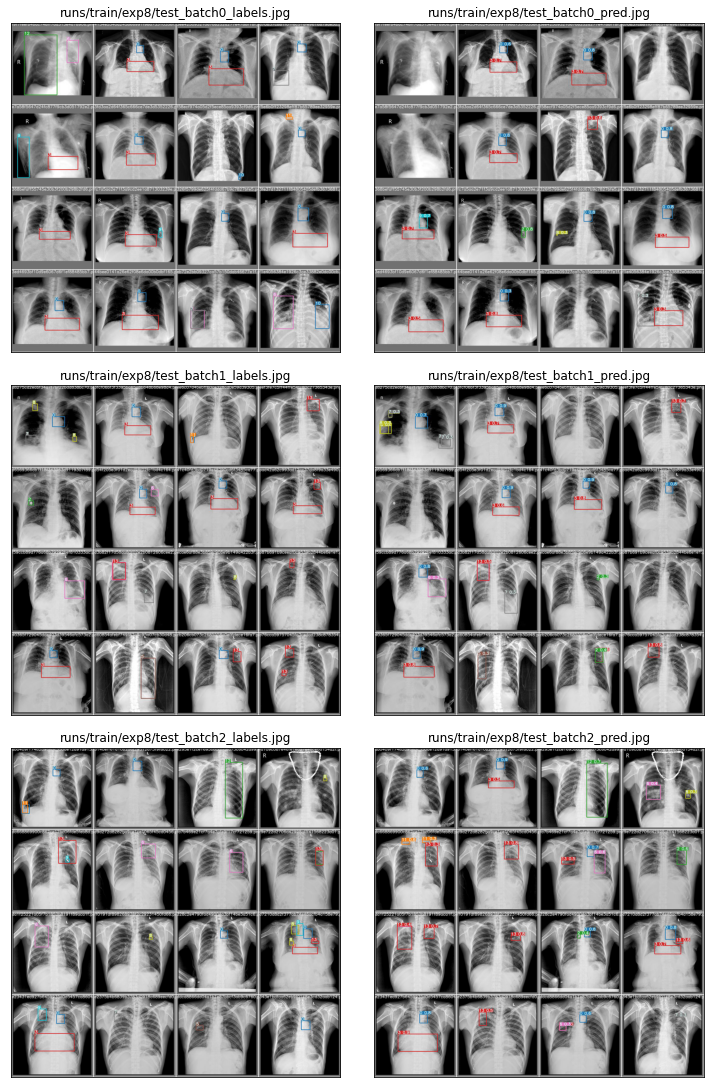

In [ ]:
fig, ax = plt.subplots(3, 2, figsize = (2*5,3*5), constrained_layout = True)
for row in range(3):
    ax[row][0].imshow(plt.imread(f'runs/train/exp8/test_batch{row}_labels.jpg'))
    ax[row][0].set_xticks([])
    ax[row][0].set_yticks([])
    ax[row][0].set_title(f'runs/train/exp8/test_batch{row}_labels.jpg', fontsize = 12)
    
    ax[row][1].imshow(plt.imread(f'runs/train/exp8/test_batch{row}_pred.jpg'))
    ax[row][1].set_xticks([])
    ax[row][1].set_yticks([])
    ax[row][1].set_title(f'runs/train/exp8/test_batch{row}_pred.jpg', fontsize = 12)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(30,30))
row = 2
ax[0].imshow(plt.imread(f'runs/train/exp8/test_batch{row}_labels.jpg'))
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title(f'ground truth labels', fontsize = 12)

ax[1].imshow(plt.imread(f'runs/train/exp8/test_batch{row}_pred.jpg'))
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title(f'predicted labels', fontsize = 12)
fig.savefig("/content/groundtruth_vs_pred.png")

# (Loss, Map) Vs Epoch

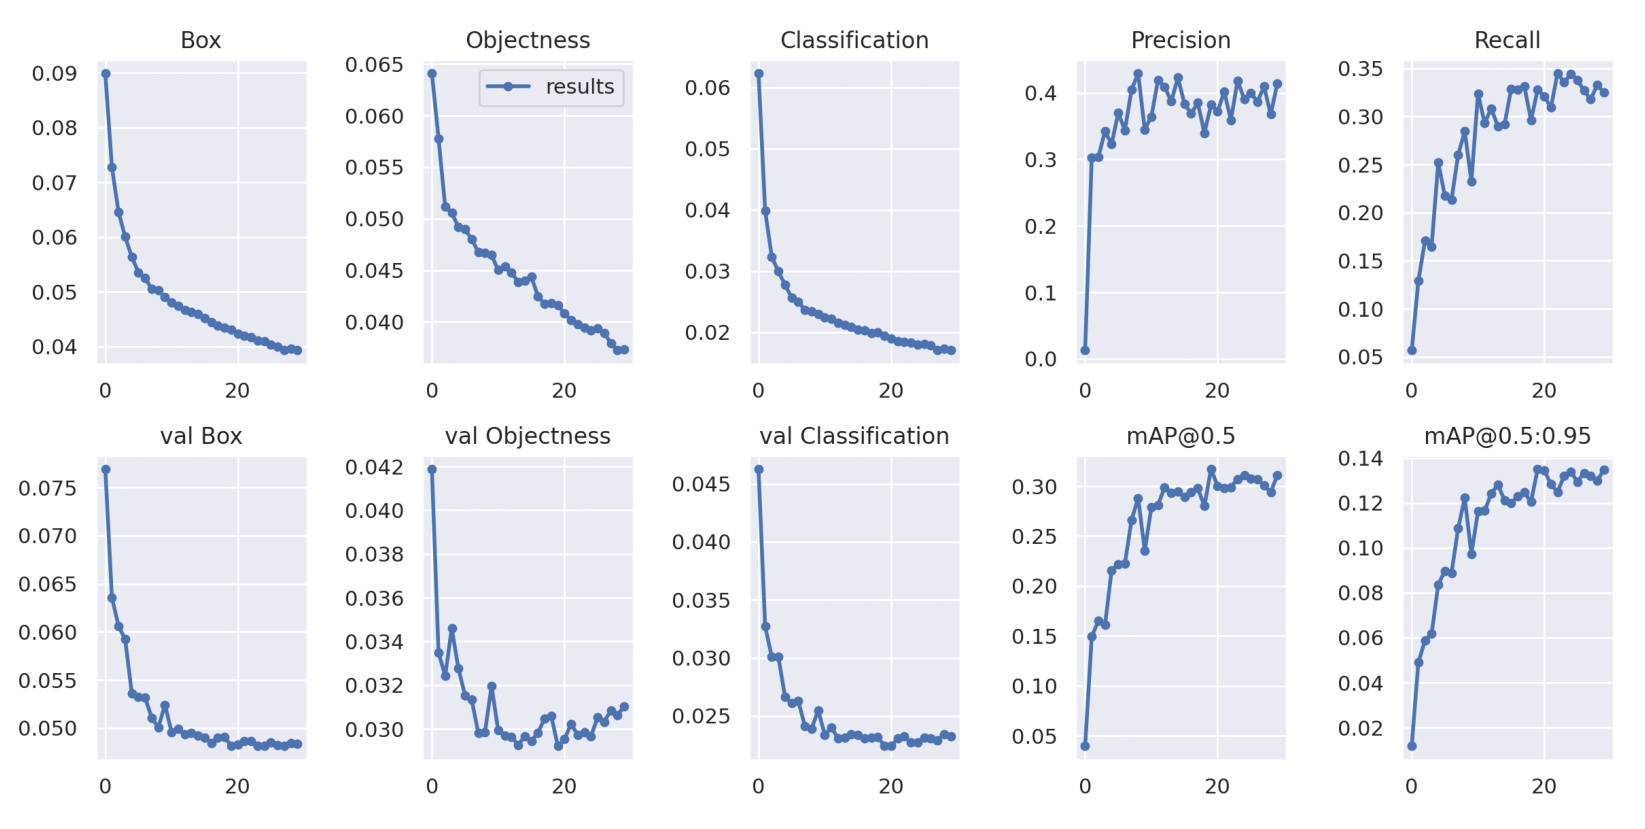

In [ ]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/results.png'));

# Confusion Matrix

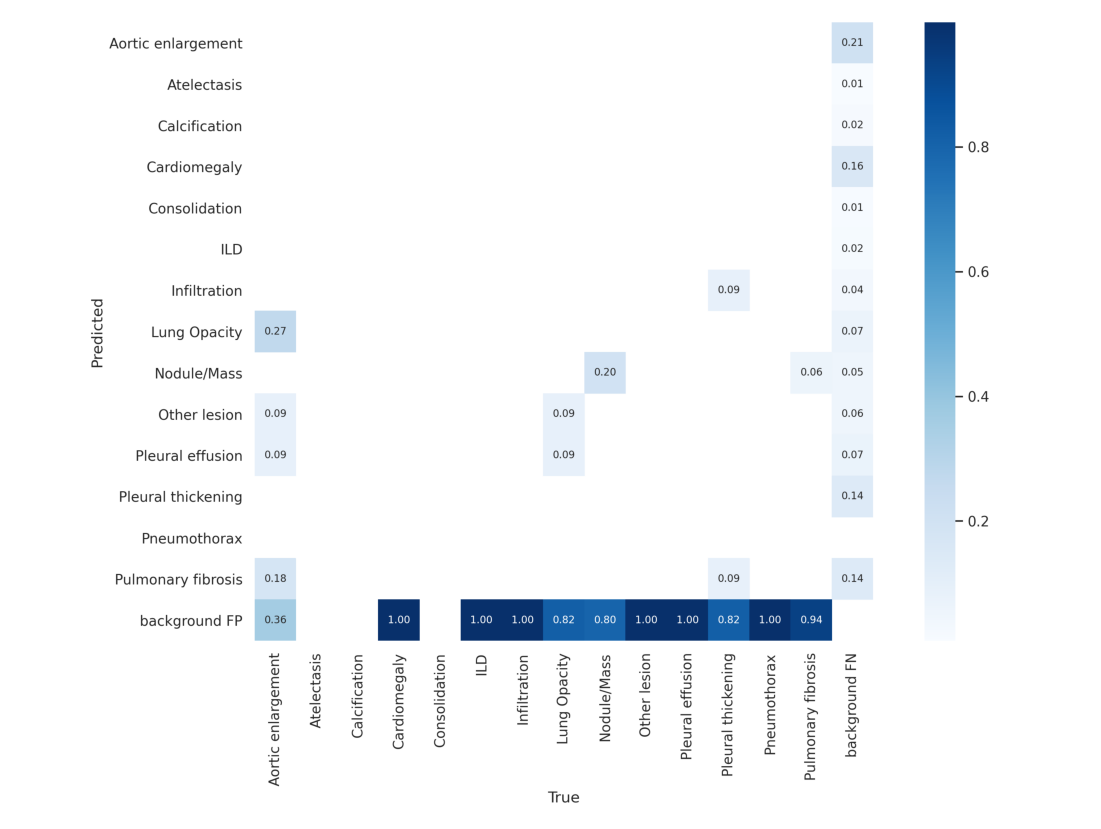

In [ ]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/confusion_matrix.png'));

# Inference

In [11]:
!cp /content/drive/MyDrive/VinBigData/images/* /content/images/

In [50]:
%cd /content/yolov5/runs/detect/exp/labels
!ls -F |grep -v / | wc -l

/content/yolov5/runs/detect/exp/labels
1691


In [47]:
%cd /content/yolov5/

/content/yolov5


In [19]:
!pip install PyYaml --upgrade

     |████████████████████████████████| 645kB 8.0MB/s 
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!python detect.py --weights '/content/best.pt' \
--img 600 \
--conf 0.15 \
--iou 0.5 \
--save-conf \
--source /content/images/ \
--exist-ok 

In [28]:
%cd /content/yolov5/runs/detect/exp/labels/
!ls -F |grep -v / | wc -l

/content/yolov5/runs/detect/exp/labels
1691


In [30]:
from os import listdir
from os.path import isfile, join

mypath = "/content/yolov5/runs/detect/exp/labels/"
labels = [f for f in listdir(mypath) if isfile(join(mypath, f))]

mypath = "/content/images/"
im_names = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [127]:
labels_path = "/content/yolov5/runs/detect/exp/labels/"
orig_images_path = "/content/drive/MyDrive/VinBigData/test_data/"
submission_arr = []
all_names = []
all_targets = []
for i, im_name in enumerate(im_names):
  im_name = im_name.split('.')[0]
  txt_name = labels_path + im_name + '.txt'
  if os.path.exists(txt_name):
    prediction_str = open(txt_name, "r")
    preds = prediction_str.readline()
    prediction_str.close() 
    # if exists
    #print("beg\n"+str(preds)+"\nend")
    orig_image_path = orig_images_path + im_name + ".dicom"
    # read dicom
    dicom = pydicom.read_file(orig_image_path)
    width = dicom.Columns
    height = dicom.Rows
    prediction_line_to_save = []
    all_names.append(im_name)
    with open(txt_name, 'r') as f:
      preds = [line.strip() for line in f]
      for row_ in preds:
        values_row = row_.split(' ')
        values_row = [float(val_) for val_ in values_row]
        if (len(values_row) != 6):
          continue
        # imname class conf box
        prediction_line_to_save.append(int(values_row[0]))
        prediction_line_to_save.append(values_row[5])
        prediction_line_to_save.append(values_row[1]*width)
        prediction_line_to_save.append(values_row[2]*height)
        prediction_line_to_save.append(values_row[3]*width)
        prediction_line_to_save.append(values_row[4]*height)
    all_targets.append(prediction_line_to_save)
    submission_arr.append(prediction_line_to_save)
  else:
    all_names.append(im_name)
    all_targets.append([14, 1, 0, 0, 1, 1])
    submission_arr.append([14, 1, 0, 0, 1, 1])
  if i % 100: print(i)

all_targets = [" ".join(str(x) for x in line) for line in all_targets]#
subm_df = pd.DataFrame({"image_id": all_names, "PredictionString": all_targets})
subm_df.head()
subm_df.to_csv('submission_yolo.csv',index=False) 
print(len(subm_df))
subm_df.head()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279


image_id                                   PredictionString
0  6d5cbffaa090403113687a73278ba98e  0 0.247437 1276.350464 929.1675 208.553984 258...
1  e9c690c6b50e976406e953e6cfdb7a0b                                       14 1 0 0 1 1
2  da4481593caa5fc2a1a7a7de90058720                                       14 1 0 0 1 1
3  2fcfb42d501dd9e3ca9fb94b532cf4de  3 0.718262 1547.9175 1363.943424 1129.1675 333...
4  7324a6d2f3cdb80878587b427f6df871  9 0.412842 1294.263684 1635.0000000000002 605....

In [115]:
%cd /content/ 

/content


In [ ]:
!python detect.py --weights '/content/yolov5/runs/train/exp8/weights/best.pt' \
--img 600 \
--conf 0.15 \
--iou 0.5 \
--source /content/drive/MyDrive/VinBigData/images/ \
--exist-ok

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.15, device='', exist_ok=True, img_size=600, iou_thres=0.5, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/drive/MyDrive/VinBigData/images/', update=False, view_img=False, weights=['/content/yolov5/runs/train/exp8/weights/best.pt'])
YOLOv5 🚀 v4.0-138-ged2c742 torch 1.8.0+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 484 layers, 88478091 parameters, 0 gradients, 220.1 GFLOPS
Traceback (most recent call last):
  File "detect.py", line 175, in <module>
    detect()
  File "detect.py", line 53, in detect
    dataset = LoadImages(source, img_size=imgsz, stride=stride)
  File "/content/yolov5/utils/datasets.py", line 148, in __init__
    assert self.nf > 0, f'No images or videos found in {p}. ' \
AssertionError: No images or videos found in /content/drive/MyDrive/VinBigData/images. Supported formats are:
images: ['bmp', 'jpg', 'jpeg', 'png', 'tif', 'tiff', 'dng

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Inference Plot

100%|██████████| 16/16 [00:00<00:00, 124.17it/s]


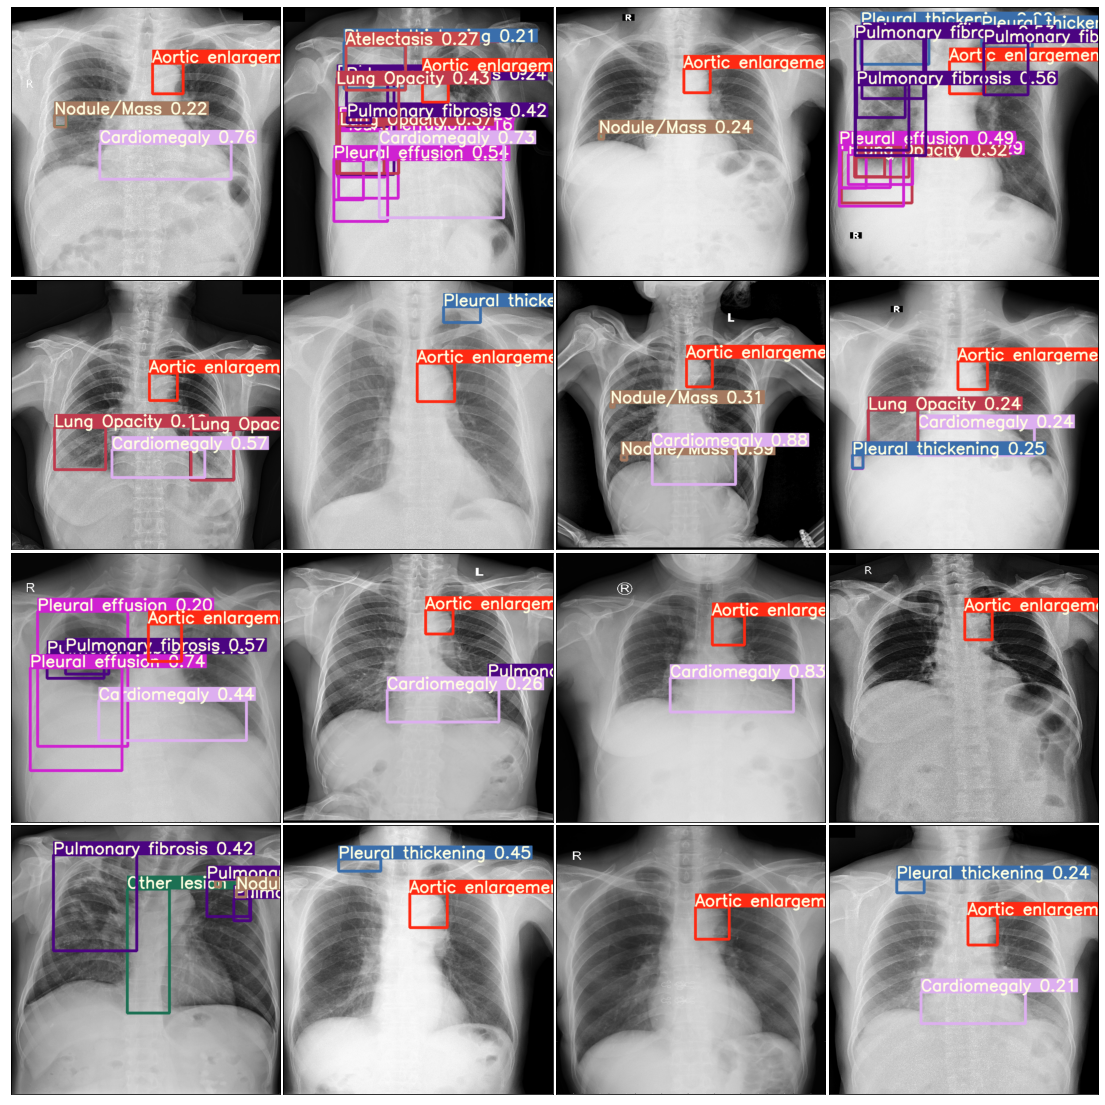

100%|██████████| 16/16 [00:00<00:00, 123.23it/s]


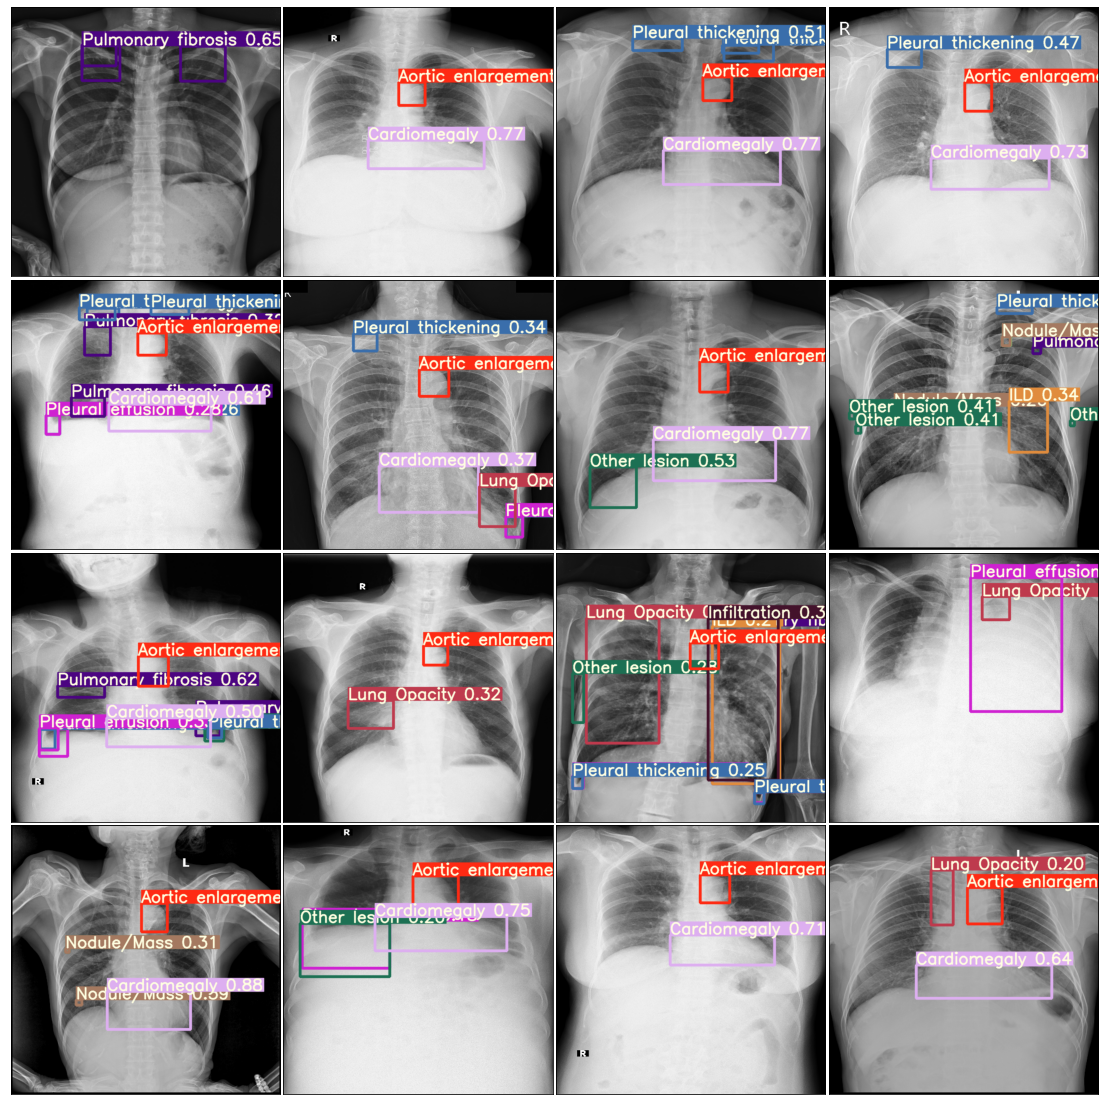

100%|██████████| 16/16 [00:00<00:00, 133.08it/s]


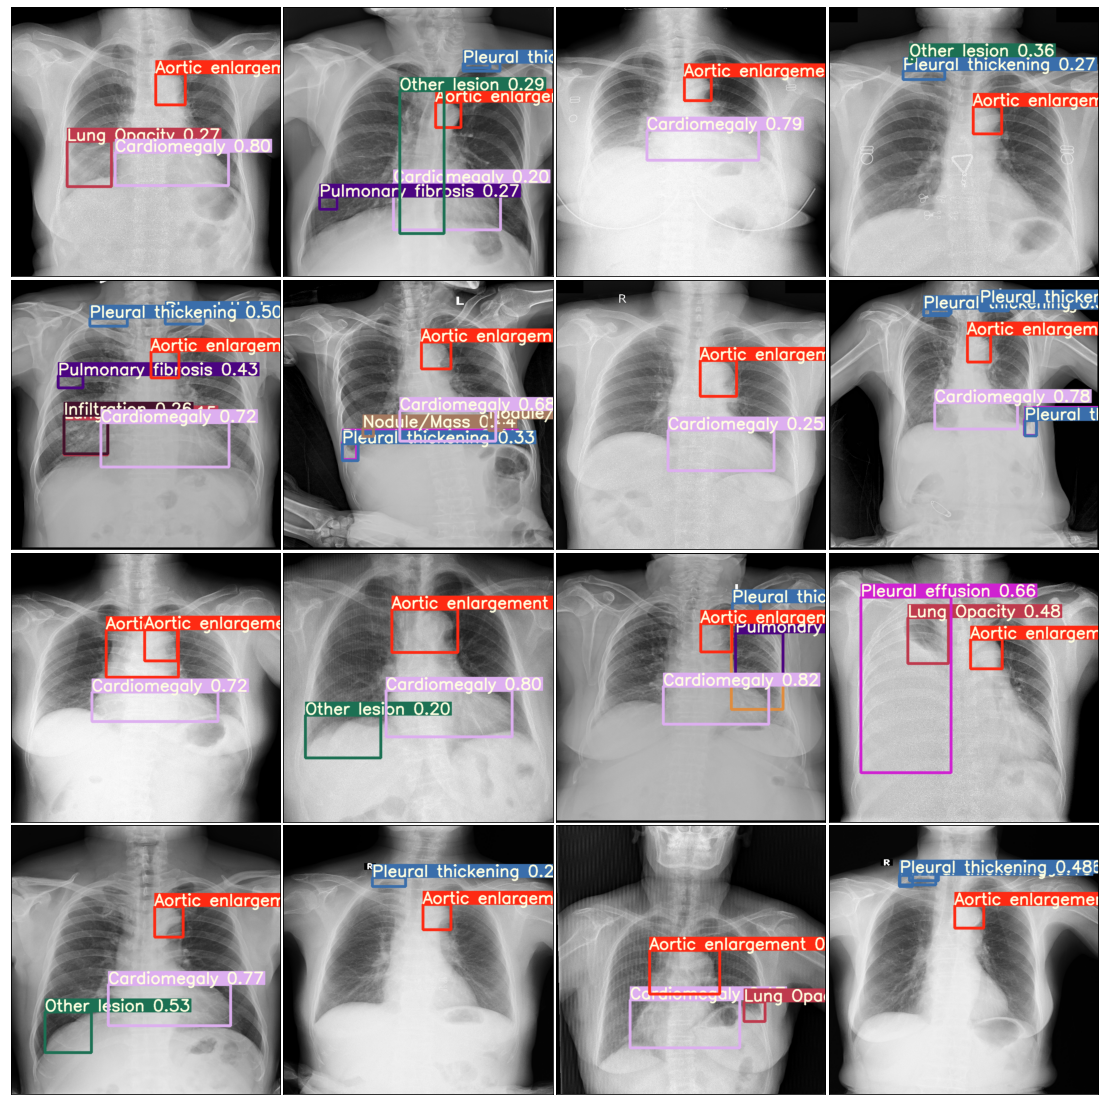

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random
import cv2
from glob import glob
from tqdm import tqdm

files = glob('runs/detect/exp/*')
for _ in range(3):
    row = 4
    col = 4
    grid_files = random.sample(files, row*col)
    images     = []
    for image_path in tqdm(grid_files):
        img          = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        images.append(img)

    fig = plt.figure(figsize=(col*5, row*5))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(col, row),  # creates 2x2 grid of axes
                     axes_pad=0.05,  # pad between axes in inch.
                     )

    for ax, im in zip(grid, images):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()